In [1]:
%load_ext watermark
%watermark -a Chan -d -v -p numpy,pandas,sklearn,konlpy,tensorflow,matplotlib,imblearn

Using TensorFlow backend.


Chan 2019-08-20 

CPython 3.7.3
IPython 7.6.1

numpy 1.16.4
pandas 0.24.2
sklearn 0.21.2
konlpy 0.5.1
tensorflow 1.14.0
matplotlib 3.1.0
imblearn 0.5.0


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt
import tensorflow as tf
from tensorflow.python.keras.preprocessing import sequence
from tensorflow import keras
from tqdm import tqdm
from collections import Counter
from matplotlib import pyplot as plt
import pickle
from utils import morp_preprocessing

# Load datasets

In [3]:
datasets = pd.read_csv('../../data/123.csv', engine='c',sep=',', encoding='utf-8')
datasets.head()

,comment,url_id,label
0,레전드 ㅋㅋㅋㅋ,12,0
1,규태를 추가하라,56,0
2,이건 쉴드불가다,12,0
3,적한테 알아서 돌진하노 ㅋㅋ,36,0
4,넛,15,0


In [4]:
import re
from konlpy.tag import Okt
okt = Okt()

def prep1(textt = '존ㄴ ㅂ신 병ㅅ 새ㄲ ㅈ나 ㅅ발 ㅁㅊ놈아'):
    pattern2 = re.compile(r'[^ 5a-zA-Zㄱ-ㅊㅌ-ㅠㅢ가-힣]')
    textt = pattern2.sub('',textt)
    temp_okt = okt.pos(textt) # , norm=True, stem=True
    
    cut_word_h = []
    cut_word_e = []
    temp = []
    
    for a in range(len(temp_okt)):
        if temp_okt[a][1] == 'Alpha':
            cut_word_e.append(temp_okt[a])
        else:
            cut_word_h.append(temp_okt[a])
    
    cut_word_h.extend(cut_word_e)
    temp.extend(cut_word_h)
    
    temp2 = []
    string1 = ''
    k = -1

    # 병신, 시발, 씨발, 존나, 느금마, 씨발롬들아, 미친놈아, 새끼, 좆밥
    bad_word = ['ㅂ', 'ㅅ', 'ㅆ', 'ㅈ', 'ㅁㅊ', 'ㄲ', 'ㄴ']
    bad_set_word = ['신', '발', '빨', '나', '놈', '끼', '밥', '문대', '대로', '망겜']
    important_class = ['KoreanParticle', 'Noun', 'mixed', 'Verb', 'Adjective', 'Alpha']
    not_important_word = ['은', '는', '이', '가', '자']

    for i in range(len(temp)):
        if temp[i][0] in bad_word:
            if i < len(temp) - 1 and len(temp) > 1 and temp[i+1][0] in bad_set_word:
                if temp[i+1][1] == 'Noun' and temp[i+1][0] not in not_important_word:
                    for j in range(i):
                        if j <= k or temp[j][1] not in important_class or (len(temp[j][0]) > 6 and temp[j][1] == 'Verb') or temp[j][0] in not_important_word:
                            continue
                        temp2.append(temp[j])
                    string1 = temp[i][0] + temp[i+1][0]
                    temp2.append((string1, 'mixed'))
                    k = i+1
            else:
                if i != 0 and len(temp[i-1][0]) == 1 and  temp[i-1][1] == 'Noun' and temp[i-1][0] not in not_important_word:
                    for j in range(i):
                        if j <= k or temp[j][1] not in important_class or (len(temp[j][0]) > 6 and temp[j][1] == 'Verb') or temp[j][0] in not_important_word:
                            continue
                        temp2.append(temp[j])
                    string1 = temp[i-1][0] + temp[i][0]
                    temp2.pop()
                    temp2.append((string1, 'mixed'))
                    k = i

        if i < len(temp) - 1 and len(temp) > 1:
            if temp[i][1] == 'Noun' and temp[i+1][1] == 'Suffix' and temp[i+1][0] not in not_important_word:
                for j in range(i):
                    if j <= k or temp[j][1] not in important_class or (len(temp[j][0]) > 6 and temp[j][1] == 'Verb') or temp[j][0] in not_important_word:
                        continue
                    temp2.append(temp[j])
                string1 = temp[i][0] + temp[i+1][0]
                temp2.append((string1, 'Noun + Suffix'))
                k = i+1
                
        # 형태소분석기가 인식못하는 예외단어
        if i < len(temp) - 1 and len(temp) > 1:
            if (temp[i][0] == '운' and temp[i+1][0] == '지') or (temp[i][0] == '노' and temp[i+1][0] == '무현')\
            or (temp[i][0] == '찐' and temp[i+1][0] == '따') or (temp[i][0] == '섹' and temp[i+1][0] == '히')\
            or (temp[i][0] == '새' and temp[i+1][0] == '키') or (temp[i][0] == '새' and temp[i+1][0] == '퀴')\
            or (temp[i][0] == '도' and temp[i+1][0] == '네') or (temp[i][0] == '장애' and temp[i+1][0] == '인색히')\
            or (temp[i][0] == '자' and temp[i+1][0] == '지') or (temp[i][0] == '고' and temp[i+1][0] == '소')\
            or (temp[i][0] == '저능' and temp[i+1][0] == '아') or (temp[i][0] == '색' and temp[i+1][0] == '히')\
            or (temp[i][0] == '쓰래' and temp[i+1][0] == '기') or (temp[i][0] == '애' and temp[i+1][0] == '미')\
            or (temp[i][0] == 'ㅅ' and temp[i+1][0] == 'ㅂ') or (temp[i][0] == 'ㅂ' and temp[i+1][0] == 'ㅅ')\
            or (temp[i][0] == 'ㅈ' and temp[i+1][0] == 'ㄹ') or (temp[i][0] == 'ㅈ' and temp[i+1][0] == 'ㄴ')\
            or (temp[i][0] == 'ㅁ' and temp[i+1][0] == 'ㅊ') or (temp[i][0] == 'ㅅ' and temp[i+1][0] == 'ㄲ')\
            or (temp[i][0] == 'ㅈ' and temp[i+1][0] == 'ㅂ') or (temp[i][0] == '섯' and temp[i+1][0] == '네')\
            or (temp[i][0] == '섰' and temp[i+1][0] == '네') or (temp[i][0] == '섯' and temp[i+1][0] == '다')\
            or (temp[i][0] == '섰' and temp[i+1][0] == '다') or (temp[i][0] == '시' and temp[i+1][0] == '발')\
            or (temp[i][0] == '새' and temp[i+1][0] == '끼') or (temp[i][0] == '개간' and temp[i+1][0] == '년')\
            or (temp[i][0] == '시부' and temp[i+1][0] == '렬') or (temp[i][0] == '쳐' and temp[i+1][0] == '받는')\
            or (temp[i][0] == '닝' and temp[i+1][0] == '기리') or (temp[i][0] == '개' and temp[i+1][0] == '공감')\
            or (temp[i][0] == '개' and temp[i+1][0] == '새기') or (temp[i][0] == '빠' and temp[i+1][0] == '가')\
            or (temp[i][0] == '개' and temp[i+1][0] == '소리') or (temp[i][0] == '개' and temp[i+1][0] == '쉽다')\
            or (temp[i][0] == '개' and temp[i+1][0] == '쉽네') or (temp[i][0] == '개' and temp[i+1][0] == '싫다')\
            or (temp[i][0] == '계' and temp[i+1][0] == '새끼') or (temp[i][0] == '김치' and temp[i+1][0] == '녀')\
            or (temp[i][0] == '에' and temp[i+1][0] == '라이') or (temp[i][0] == '관' and temp[i+1][0] == '종')\
            or (temp[i][0] == '괘' and temp[i+1][0] == '새끼') or (temp[i][0] == '그' and temp[i+1][0] == '켬')\
            or (temp[i][0] == '꼬' and temp[i+1][0] == '라지') or (temp[i][0] == '노' and temp[i+1][0] == '알라')\
            or (temp[i][0] == '노친' and temp[i+1][0] == '네') or (temp[i][0] == '눈' and temp[i+1][0] == '깔')\
            or (temp[i][0] == '니' and temp[i+1][0] == '년') or (temp[i][0] == '이' and temp[i+1][0] == '년')\
            or (temp[i][0] == '머' and temp[i+1][0] == '갈') or (temp[i][0] == '덜' and temp[i+1][0] == '떨어진')\
            or (temp[i][0] == '시' and temp[i+1][0] == '바알') or (temp[i][0] == '또' and temp[i+1][0] == '라인')\
            or (temp[i][0] == '시' and temp[i+1][0] == '펄') or (temp[i][0] == '디' and temp[i+1][0] == '쥐고싶냐')\
            or (temp[i][0] == '병' and temp[i+1][0] == '신') or (temp[i][0] == '존' and temp[i+1][0] == '나')\
            or (temp[i][0] == '섹' and temp[i+1][0] == '스') or (temp[i][0] == '니' and temp[i+1][0] == '미')\
            or (temp[i][0] == '미' and temp[i+1][0] == '친') or (temp[i][0] == '느' and temp[i+1][0] == '그')\
            or (temp[i][0] == '어' and temp[i+1][0] == '미') or (temp[i][0] == '느' and temp[i+1][0] == '금')\
            or (temp[i][0] == '메' and temp[i+1][0] == '갈') or (temp[i][0] == '일' and temp[i+1][0] == '베')\
            or (temp[i][0] == '병' and temp[i+1][0] == '자') or (temp[i][0] == '장' and temp[i+1][0] == '애')\
            or (temp[i][0] == '씨' and temp[i+1][0] == '발') or (temp[i][0] == '븽' and temp[i+1][0] == '신')\
            or (temp[i][0] == '빨' and temp[i+1][0] == '아') or (temp[i][0] == '새' and temp[i+1][0] == '낀데')\
            or (temp[i][0] == '개' and temp[i+1][0] == '같이') or (temp[i][0] == '슴' and temp[i+1][0] == '가')\
            or (temp[i][0] == '정신병' and temp[i+1][0] == '자') or (temp[i][0] == '친구' and temp[i+1][0] == '년')\
            or (temp[i][0] == '오' and temp[i+1][0] == '지구') or (temp[i][0] == '오' and temp[i+1][0] == '쪘')\
            or (temp[i][0] == '5' and temp[i+1][0] == '졌') or (temp[i][0] == '5' and temp[i+1][0] == '지구')\
            or (temp[i][0] == '5' and temp[i+1][0] == '지네') or (temp[i][0] == '5' and temp[i+1][0] == '지고')\
            or (temp[i][0] == '머리' and temp[i+1][0] == '텅') or (temp[i][0] == '쪼' and temp[i+1][0] == '다')\
            or (temp[i][0] == '디' and temp[i+1][0] == '질') or (temp[i][0] == '뒤' and temp[i+1][0] == '질')\
            or (temp[i][0] == '디' and temp[i+1][0] == '졌') or (temp[i][0] == '딴' and temp[i+1][0] == '년')\
            or (temp[i][0] == '또' and temp[i+1][0] == '라이') or (temp[i][0] == '똘' and temp[i+1][0] == '아이')\
            or (temp[i][0] == '오' and temp[i+1][0] == '쪘') or (temp[i][0] == '명존' and temp[i+1][0] == '쎄')\
            or (temp[i][0] == '미시' and temp[i+1][0] == '친발') or (temp[i][0] == '주' and temp[i+1][0] == '겨')\
            or (temp[i][0] == '윾' and temp[i+1][0] == '두') or (temp[i][0] == '기' and temp[i+1][0] == '무띠')\
            or (temp[i][0] == '죽여뿌' and temp[i+1][0] == '고') or (temp[i][0] == '미' and temp[i+1][0] == '틴')\
            or (temp[i][0] == '별' and temp[i+1][0] == '창') or (temp[i][0] == '색' and temp[i+1][0] == '희')\
            or (temp[i][0] == '수준' and temp[i+1][0] == '하고는') or (temp[i][0] == '쉬이' and temp[i+1][0] == '바')\
            or (temp[i][0] == '시미' and temp[i+1][0] == '발친') or (temp[i][0] == '시미' and temp[i+1][0] == '친발')\
            or (temp[i][0] == '시' and temp[i+1][0] == '부울') or (temp[i][0] == '시방' and temp[i+1][0] == '새')\
            or (temp[i][0] == '시불' and temp[i+1][0] == '탱') or (temp[i][0] == '시' and temp[i+1][0] == '빨')\
            or (temp[i][0] == '시' and temp[i+1][0] == '이발') or (temp[i][0] == '개시' and temp[i+1][0] == '키')\
            or (temp[i][0] == '시' and temp[i+1][0] == '팔') or (temp[i][0] == '십' and temp[i+1][0] == '창')\
            or (temp[i][0] == '쓰' and temp[i+1][0] == '렉') or (temp[i][0] == '씨' and temp[i+1][0] == '바라')\
            or (temp[i][0] == '씨방' and temp[i+1][0] == '새') or (temp[i][0] == '개' and temp[i+1][0] == '년')\
            or (temp[i][0] == '개' and temp[i+1][0] == '같네') or (temp[i][0] == '개' and temp[i+1][0] == '같아')\
            or (temp[i][0] == '개' and temp[i+1][0] == '같다') or (temp[i][0] == '처' and temp[i+1][0] == '먹어')\
            or (temp[i][0] == '처' and temp[i+1][0] == '먹다') or (temp[i][0] == '처' and temp[i+1][0] == '먹여')\
            or (temp[i][0] == '씨' and temp[i+1][0] == '이발') or (temp[i][0] == '씨' and temp[i+1][0] == '바알')\
            or (temp[i][0] == '졀' and temp[i+1][0] == '라') or (temp[i][0] == '졌' and temp[i+1][0] == '같은')\
            or (temp[i][0] == '조' and temp[i+1][0] == '낸') or (temp[i][0] == '족' and temp[i+1][0] == '까')\
            or (temp[i][0] == '존' and temp[i+1][0] == '쎄') or (temp[i][0] == '좁' and temp[i+1][0] == '밥')\
            or (temp[i][0] == '종' and temp[i+1][0] == '나') or (temp[i][0] == '싸' and temp[i+1][0] == '물어')\
            or (temp[i][0] == '닭' and temp[i+1][0] == '쳐') or (temp[i][0] == '닦' and temp[i+1][0] == '쳐')\
            or (temp[i][0] == '닭' and temp[i+1][0] == '근혜') or (temp[i][0] == '쥐박' and temp[i+1][0] == '이')\
            or (temp[i][0] == '죵' and temp[i+1][0] == '나') or (temp[i][0] == '줬' and temp[i+1][0] == '같은')\
            or (temp[i][0] == '쥰' and temp[i+1][0] == '나') or (temp[i][0] == '쥰' and temp[i+1][0] == '니')\
            or (temp[i][0] == '지' and temp[i+1][0] == '롤') or (temp[i][0] == '와' and temp[i+1][0] == '꾸')\
            or (temp[i][0] == '짱' and temp[i+1][0] == '께') or (temp[i][0] == '존' and temp[i+1][0] == '맛')\
            or (temp[i][0] == '쳐' and temp[i+1][0] == '먹어') or (temp[i][0] == '쳐' and temp[i+1][0] == '먹다')\
            or (temp[i][0] == '쳐' and temp[i+1][0] == '발라') or (temp[i][0] == '쳐' and temp[i+1][0] == '바르다')\
            or (temp[i][0] == '개' and temp[i+1][0] == '사기') or (temp[i][0] == '오지' and temp[i+1][0] == '네')\
            or (temp[i][0] == '지' and temp[i+1][0] == '린다') or (temp[i][0] == '지리' and temp[i+1][0] == '네')\
            or (temp[i][0] == '십' and temp[i+1][0] == '가능') or (temp[i][0] == '빡' and temp[i+1][0] == '고수')\
            or (temp[i][0] == '라인' and temp[i+1][0] == '빨') or (temp[i][0] == '개' and temp[i+1][0] == '무시')\
            or (temp[i][0] == '뇨' and temp[i+1][0] == '속') or (temp[i][0] == '찌리' and temp[i+1][0] == '네')\
            or (temp[i][0] == '시' and temp[i+1][0] == '부레')\
            :
                for j in range(i):
                    if j <= k or temp[j][1] not in important_class or (len(temp[j][0]) > 6 and temp[j][1] == 'Verb') or temp[j][0] in not_important_word:
                        continue
                    temp2.append(temp[j])
                string1 = temp[i][0] + temp[i+1][0]
                temp2.append((string1, 'Except'))
                k = i+1
                
        # 형태소분석기가 인식못하는 예외단어(3글자)
        if i < len(temp) - 2 and len(temp) > 2:
            if (temp[i][0] == '앙' and temp[i+1][0] == '기' and temp[i+2][0] == '무')\
            or (temp[i][0] == '앙' and temp[i+1][0] == '기' and temp[i+2][0] == '무띠')\
            or (temp[i][0] == '보' and temp[i+1][0] == '딩고' and temp[i+2][0] == '지')\
            or (temp[i][0] == '앙' and temp[i+1][0] == '기모' and temp[i+2][0] == '띄')\
            or (temp[i][0] == '시' and temp[i+1][0] == '새' and temp[i+2][0] == '발끼')\
            or (temp[i][0] == '씨' and temp[i+1][0] == '새' and temp[i+2][0] == '발끼')\
            or (temp[i][0] == '시' and temp[i+1][0] == '친' and temp[i+2][0] == '발미')\
            or (temp[i][0] == '죠' and temp[i+1][0] == '온' and temp[i+2][0] == '나')\
            or (temp[i][0] == '에' and temp[i+1][0] == '반' and temp[i+2][0] == '데')\
            or (temp[i][0] == '개' and temp[i+1][0] == '웃' and temp[i+2][0] == '기네')\
            :
                for j in range(i):
                    if j <= k or temp[j][1] not in important_class or (len(temp[j][0]) > 6 and temp[j][1] == 'Verb') or temp[j][0] in not_important_word:
                        continue
                    temp2.append(temp[j])
                string1 = temp[i][0] + temp[i+1][0] + temp[i+2][0]
                temp2.append((string1, 'Except'))
                k = i+2
        
        # 형태소분석기가 인식못하는 예외단어(4글자)
        if i < len(temp) - 3 and len(temp) > 3:
            if (temp[i][0] == '앙' and temp[i+1][0] == '기' and temp[i+2][0] == '모' and temp[i+3][0] == '띠')\
            or (temp[i][0] == '앙' and temp[i+1][0] == '기' and temp[i+2][0] == '모' and temp[i+3][0] == '딱')\
            :
                for j in range(i):
                    if j <= k or temp[j][1] not in important_class or (len(temp[j][0]) > 6 and temp[j][1] == 'Verb') or temp[j][0] in not_important_word:
                        continue
                    temp2.append(temp[j])
                string1 = temp[i][0] + temp[i+1][0] + temp[i+2][0] + temp[i+3][0]
                temp2.append((string1, 'Except'))
                k = i+3
        
        # 예외단어(엿)
        if temp[i][0] == '엿'and temp[i][1] == 'Modifier':
            for j in range(i):
                if j <= k or temp[j][1] not in important_class or (len(temp[j][0]) > 6 and temp[j][1] == 'Verb') or temp[j][0] in not_important_word:
                    continue
                temp2.append(temp[j])
            string1 = temp[i][0]
            temp2.append((string1, 'Except'))
            k = i
            
    else:
        for j in range(len(temp)):
            if j <= k or temp[j][1] not in important_class or (len(temp[j][0]) > 6 and temp[j][1] == 'Verb') or temp[j][0] in not_important_word:
                continue
            temp2.append(temp[j])

    result = []
    
    for b in range(len(temp2)):
        result.append(temp2[b][0])
    
    return result

In [5]:
def prep2(datasets):
    '''
    dataframe을 넣어주세요
    '''
    chat = list()
    for i,j in enumerate(datasets.comment.values):
        temp = []
        temp.append(prep1(j))
        if temp == [[]]:
            datasets.drop(i, inplace=True)
            continue
        else:
            chat.extend(temp)
    
    return chat

In [6]:
abc = prep2(datasets)

In [7]:
abc

[['레전드'],
 ['규태', '추가하'],
 ['이건', '쉴드', '불가'],
 ['적', '알아서', '돌진', '하노'],
 ['넛'],
 ['개'],
 ['게임', '장르', '계속', '바', '껴'],
 ['픽하', '레전드'],
 ['속'],
 ['ㄹㅇ'],
 ['시작'],
 ['시한', '부채', '널'],
 ['페이커'],
 ['아니', '스테이지', '진짜', '내', '초딩', '조카', '깬다고'],
 ['그켬', '쓰'],
 ['아닛'],
 ['메카', '닉', '하시지', 'ㅜㅜ'],
 ['싸움', '거', '같습니다'],
 ['ㄹㅇ', '이겨야지'],
 ['아무', '형', '스타', '듀', '리', '캐릭터', '강간', '하는거', '다른거', '하자'],
 ['장로', 'ㅈㄱㅈ', '를'],
 ['난', '맞고는', '살아'],
 ['어그', '끄네', 'ㄷㄷㄷ'],
 ['뒤', '구린', '새끼'],
 ['히오스', '다시', '깔러', '갑니다'],
 ['쌍날', '단검', 'ㄷㄷ'],
 ['명'],
 ['쿨가이'],
 ['안됨'],
 ['마나', '수정', '들었어야', '컨셉', '맞는데'],
 ['첨', '아이중', '명', '씨'],
 ['또', '또'],
 ['보라', '단', '크트'],
 ['왔다'],
 ['신통', '방통'],
 ['거짓말', '만하', '스트리머', '퇴', '출', '되어야', '합니다', '여러분'],
 ['카서스', '성', '현실', '성은', '없긴', '무섭네'],
 ['체리형', '앵'],
 ['어렵다', '재는'],
 ['럭키짱'],
 ['방'],
 ['엌'],
 ['진자'],
 ['올라프', '그', '자체'],
 ['뽀갰어'],
 ['아아', '것', '자동', '문', '것'],
 ['오반'],
 ['황금', '단', '없으면', '노잼'],
 ['여기', '보다', '자돈곳', '같은데', '진행', '얼마나', '된건', '가요'],
 ['그냥', '던지고', '숨

In [50]:
datasets.columns

Index(['comment', 'url_id', 'label'], dtype='object')

In [51]:
datasets.comment

0                                         레전드 ㅋㅋㅋㅋ
1                                         규태를 추가하라
2                                         이건 쉴드불가다
3                                  적한테 알아서 돌진하노 ㅋㅋ
4                                                넛
5                                               7개
6                                     게임 장르가 계속 바껴
7                                               킁킁
8                                        다른픽하면 레전드
9                                         공속 ㅋㅋㅋㅋㅋ
10                                              ㄹㅇ
11                                        시작부터 ㅋㅋㅋ
12                                               ?
13                           ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
14                                           시한부채널
15                                         3페이커ㅋㅋㅋ
16                      아니 스테이지 1은 진짜 내 초딩 조카도 깬다고
17                                        ? ㅋㅋㅋㅋㅋㅋ
18                                      그켬쓰 ㅋㅋㅋㅋㅋㅋ
19                             

In [1]:
datasets = pd.read_csv('../../data/train.csv', engine='python', encoding='utf-16')
datasets.head()

NameError: name 'pd' is not defined

In [116]:
datasets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Data columns (total 4 columns):
Unnamed: 0    42000 non-null int64
comment       42000 non-null object
url_id        42000 non-null int64
label         42000 non-null int64
dtypes: int64(3), object(1)
memory usage: 1.3+ MB


# 형태소분석

In [149]:
import re
from konlpy.tag import Okt
okt = Okt()

def prep1(textt = '존ㄴ ㅂ신 병ㅅ 새ㄲ ㅈ나 ㅅ발 ㅁㅊ놈아'):
    pattern2 = re.compile(r'[^ a-zA-Zㄱ-ㅊㅌ-ㅠㅢ-힣]')
    textt = pattern2.sub('',textt)
    temp_okt = okt.pos(textt)
    
    cut_word_h = []
    cut_word_e = []
    temp = []
    
    for a in range(len(temp_okt)):
        if temp_okt[a][1] == 'Alpha':
            cut_word_e.append(temp_okt[a])
        else:
            cut_word_h.append(temp_okt[a])
    
    cut_word_h.extend(cut_word_e)
    temp.extend(cut_word_h)
    
    temp2 = []
    string1 = ''
    k = -1

    # 병신, 시발, 씨발, 존나, 느금마, 씨발롬들아, 미친놈아, 새끼, 좆밥
    bad_word = ['ㅂ', 'ㅅ', 'ㅆ', 'ㅈ', 'ㅁㅊ', 'ㄲ', 'ㄴ']
    bad_set_word = ['신', '발', '빨', '나', '놈', '끼', '밥']
    important_class = ['KoreanParticle', 'Noun', 'mixed', 'Verb', 'Alpha']
    not_important_word = ['은', '는', '이', '가', '자']

    for i in range(len(temp)):
        if temp[i][0] in bad_word:
            if i != len(temp) - 1 and temp[i+1][0] in bad_set_word:
                if len(temp[i+1][0]) == 1 and temp[i+1][1] == 'Noun' and temp[i+1][0] not in not_important_word:
                    for j in range(i):
                        if j <= k or temp[j][1] not in important_class or (len(temp[j][0]) > 4 and temp[j][1] == 'Verb') or temp[j][0] in not_important_word:
                            continue
                        temp2.append(temp[j])
                    string1 = temp[i][0] + temp[i+1][0]
                    temp2.append((string1, 'mixed'))
                    k = i+1
            else:
                if i != 0 and len(temp[i-1][0]) == 1 and  temp[i-1][1] == 'Noun' and temp[i-1][0] not in not_important_word:
                    for j in range(i):
                        if j <= k or temp[j][1] not in important_class or (len(temp[j][0]) > 4 and temp[j][1] == 'Verb') or temp[j][0] in not_important_word:
                            continue
                        temp2.append(temp[j])
                    string1 = temp[i-1][0] + temp[i][0]
                    temp2.pop()
                    temp2.append((string1, 'mixed'))
                    k = i

        if i != len(temp) - 1:
            if temp[i][1] == 'Noun' and temp[i+1][1] == 'Suffix' and temp[i+1][0] not in not_important_word:
                for j in range(i):
                    if j <= k or temp[j][1] not in important_class or (len(temp[j][0]) > 4 and temp[j][1] == 'Verb') or temp[j][0] in not_important_word:
                        continue
                    temp2.append(temp[j])
                string1 = temp[i][0] + temp[i+1][0]
                temp2.append((string1, 'Noun + Suffix'))
                k = i+1
                
        # 형태소분석기가 인식못하는 예외단어
        if i != len(temp) - 1:
            if (temp[i][0] == '운' and temp[i+1][0] == '지') or (temp[i][0] == '노' and temp[i+1][0] == '무현')\
            or (temp[i][0] == '찐' and temp[i+1][0] == '따') or (temp[i][0] == '섹' and temp[i+1][0] == '히')\
            or (temp[i][0] == '새' and temp[i+1][0] == '키') or (temp[i][0] == '새' and temp[i+1][0] == '퀴')\
            or (temp[i][0] == '도' and temp[i+1][0] == '네') or (temp[i][0] == '장애' and temp[i+1][0] == '인색히')\
            or (temp[i][0] == '자' and temp[i+1][0] == '지') or (temp[i][0] == '고' and temp[i+1][0] == '소')\
            or (temp[i][0] == '저능' and temp[i+1][0] == '아') or (temp[i][0] == '색' and temp[i+1][0] == '히')\
            or (temp[i][0] == '쓰래' and temp[i+1][0] == '기') or (temp[i][0] == '애' and temp[i+1][0] == '미')\
            or (temp[i][0] == 'ㅅ' and temp[i+1][0] == 'ㅂ') or (temp[i][0] == 'ㅂ' and temp[i+1][0] == 'ㅅ')\
            or (temp[i][0] == 'ㅈ' and temp[i+1][0] == 'ㄹ') or (temp[i][0] == 'ㅈ' and temp[i+1][0] == 'ㄴ')\
            or (temp[i][0] == 'ㅁ' and temp[i+1][0] == 'ㅊ') or (temp[i][0] == 'ㅅ' and temp[i+1][0] == 'ㄲ')\
            or (temp[i][0] == 'ㅈ' and temp[i+1][0] == 'ㅂ') or (temp[i][0] == '섯' and temp[i+1][0] == '네')\
            or (temp[i][0] == '섰' and temp[i+1][0] == '네') or (temp[i][0] == '섯' and temp[i+1][0] == '다')\
            or (temp[i][0] == '섰' and temp[i+1][0] == '다'):
                for j in range(i):
                    if j <= k or temp[j][1] not in important_class or (len(temp[j][0]) > 4 and temp[j][1] == 'Verb') or temp[j][0] in not_important_word:
                        continue
                    temp2.append(temp[j])
                string1 = temp[i][0] + temp[i+1][0]
                temp2.append((string1, 'Except'))
                k = i+1
        
    else:
        for j in range(len(temp)):
            if j <= k or temp[j][1] not in important_class or (len(temp[j][0]) > 4 and temp[j][1] == 'Verb') or temp[j][0] in not_important_word:
                continue
            temp2.append(temp[j])

    result = []
    
    for b in range(len(temp2)):
        result.append(temp2[b][0])
    
    return result

In [163]:
datasets.comment

0                                                       ㅜㅜ
2                                                        헐
3                                                       제시
4                                                    이거인 듯
5                                                     개써글겜
6                                                       ㅇㅈ
7                                             손 찧으면 진짜 아픈데
8                                                ㅇ우무 말고 몰왕
10       ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ노틸 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
12                                                  모드충돌이래
13                                                 방광 받음안됨
15                                                       밥
16                                           궁금하시면 방송직접보세요
17                                                 궁은 순수너프
18                                                    ㄴㅇㅂㅈ
19                                                      람각
20                                                 잘짜 고생

In [151]:
chat = list()
for i,j in enumerate(datasets.comment.values):
    temp = []
    temp.append(prep1(j))
    if temp == [[]]:
        datasets.drop(i, inplace=True)
        continue
    else:
        chat.extend(temp)
chat[:5]

[['ㅜㅜ'], ['헐'], ['제시'], ['거인', '듯'], ['개써', '글겜']]

In [25]:
datasets.label

0        0
1        0
2        0
3        0
4        0
5        0
6        0
8        0
9        0
10       0
11       0
14       0
15       0
16       0
18       1
19       0
20       0
21       0
22       0
23       1
24       0
25       0
26       0
27       1
28       0
29       0
30       0
31       0
33       0
34       0
        ..
11965    0
11966    0
11967    0
11969    0
11970    0
11971    0
11972    0
11973    0
11976    0
11977    0
11978    0
11980    1
11981    0
11982    0
11983    0
11984    0
11985    0
11986    0
11987    0
11988    0
11989    0
11990    0
11991    0
11992    0
11994    0
11995    0
11996    0
11997    1
11998    0
11999    0
Name: label, Length: 9715, dtype: int64

In [152]:
vocab_size = 30000

pad_id = 0
oov_id = 1
index_offset = 1

def make_vocab(sentences):
    word_counter = Counter()

    for sent in sentences:
        word_counter.update(sent)

    most_common = word_counter.most_common()
    print("고빈도 단어:")
    for k, v in most_common[:10]:
        print(k, ": ", v)

    vocab = {
    '<PAD>': pad_id,
    '<OOV>': oov_id
    }
    for i, (word, cnt) in enumerate(most_common, start=index_offset+1):
        vocab[word] = i
        if len(vocab) >= vocab_size:
            break

    return vocab

word_index = make_vocab(chat)
word_inverted_index = {v:k for k, v in word_index.items()}

print("\n단어 사전:")
for i in range(0, 10):
    print(i, word_inverted_index[i])

print("\n단어 사전 크기: ", len(word_index))

# # vocab save
# with open('./vocab/vocab_index.pickle', 'wb') as f:
#     pickle.dump(word_index, f, pickle.HIGHEST_PROTOCOL)
# with open('./vocab/vocab_inverted_index.pickle', 'wb') as f:
#     pickle.dump(word_inverted_index, f, pickle.HIGHEST_PROTOCOL)

고빈도 단어:
와 :  645
ㄷㄷ :  621
진짜 :  494
거 :  468
채팅 :  468
형 :  450
중 :  428
창 :  408
싹둑 :  398
관리 :  387

단어 사전:
0 <PAD>
1 <OOV>
2 와
3 ㄷㄷ
4 진짜
5 거
6 채팅
7 형
8 중
9 창

단어 사전 크기:  20185


In [153]:
def index_to_text(indexes):
    return ' '.join([word_inverted_index[i] for i in indexes])

def text_to_index(tokens):
    indexes = []
    for tok in tokens:
        if tok in word_index:
            indexes.append(word_index[tok])
        else:
            indexes.append(oov_id)

    return indexes

print("원본: ", chat[2])
ids = text_to_index(chat[2])
print("문자 -> 숫자: ", ids)
print("숫자 -> 문자: ", index_to_text(ids))

원본:  ['제시']
문자 -> 숫자:  [5050]
숫자 -> 문자:  제시


In [154]:
x_variable = [text_to_index(_) for _ in chat]

sentence_size = 10
x_padded = sequence.pad_sequences(x_variable,
                                 maxlen=sentence_size,
                                 truncating='post',
                                 padding='post',
                                 value=pad_id)

In [155]:
def plot_loss(history):
    plt.figure(figsize=(6,5))
    val = plt.plot(history.epoch, history.history['val_loss'],
                 '--', label='Test')
    plt.plot(history.epoch, history.history['loss'], color=val[0].get_color(),
           label='Train')

    plt.xlabel('Epochs')
    plt.ylabel("Loss")
    plt.legend()

    plt.xlim([0,max(history.epoch)])

In [156]:
import warnings
warnings.filterwarnings(action='once')


# 데이터 클래스 불균형 문제 해결하자

## Downsampling

In [157]:
down_X, down_y = RandomUnderSampler().fit_resample(x_padded, datasets.label)

# 총 데이터 수 , 1 레이블 데이터 수
len(down_y), down_y.sum()

(4110, 2055)

In [158]:
X_train, X_test, y_train, y_test = train_test_split(down_X, down_y)

In [159]:
model_down = keras.Sequential([
    keras.layers.Embedding(30000, 10),
    keras.layers.Conv1D(64, 3, padding="same", activation=tf.nn.relu,),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation=tf.nn.sigmoid)
])

Train on 3082 samples, validate on 1028 samples
Epoch 1/5
3082/3082 [==============================] - ETA: 1:31 - loss: 0.6926 - recall_15: 0.687 - ETA: 31s - loss: 0.6933 - recall_15: 0.708 - ETA: 19s - loss: 0.6934 - recall_15: 0.65 - ETA: 14s - loss: 0.6937 - recall_15: 0.62 - ETA: 10s - loss: 0.6946 - recall_15: 0.59 - ETA: 8s - loss: 0.6943 - recall_15: 0.5911 - ETA: 7s - loss: 0.6939 - recall_15: 0.591 - ETA: 6s - loss: 0.6934 - recall_15: 0.597 - ETA: 6s - loss: 0.6936 - recall_15: 0.585 - ETA: 5s - loss: 0.6935 - recall_15: 0.584 - ETA: 5s - loss: 0.6935 - recall_15: 0.586 - ETA: 4s - loss: 0.6935 - recall_15: 0.574 - ETA: 4s - loss: 0.6936 - recall_15: 0.570 - ETA: 4s - loss: 0.6936 - recall_15: 0.560 - ETA: 3s - loss: 0.6936 - recall_15: 0.560 - ETA: 3s - loss: 0.6935 - recall_15: 0.558 - ETA: 3s - loss: 0.6934 - recall_15: 0.553 - ETA: 3s - loss: 0.6933 - recall_15: 0.546 - ETA: 2s - loss: 0.6933 - recall_15: 0.540 - ETA: 2s - loss: 0.6932 - recall_15: 0.536 - ETA: 2s - los

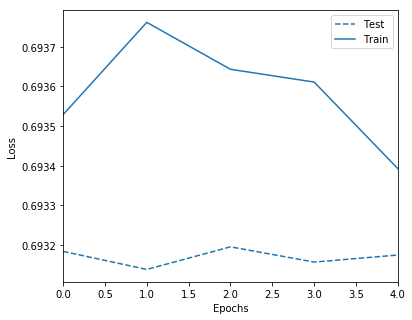

In [160]:
model_down.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall()])

history = model_down.fit(X_train,
          pd.get_dummies(y_train),
          epochs=5,
          validation_data=(X_test, pd.get_dummies(y_test))
         )
plot_loss(history)
test_loss, test_acc = model_down.evaluate(X_test, pd.get_dummies(y_test))
print('Test Recall:', test_acc)

In [161]:
#recall
recall_score(y_test, model_down.predict_classes(X_test)), \
accuracy_score(y_test, model_down.predict_classes(X_test)),\
f1_score(y_test, model_down.predict_classes(X_test))

(1.0, 0.4961089494163424, 0.6631989596879064)

In [162]:
print('전체채팅수{}, 예측유해채팅수{}'.format(len(X_test),model_down.predict_classes(X_test).sum()))

전체채팅수1028, 예측유해채팅수1028


## 모델 체크포인트 저장

In [115]:
model_down.save('../model/cnn_undersample.h5')

# TODO
- 형태소별 Tokenize 말고 한글 자모별 Tokenize 하여 실험해보기
- CNN layer / Parameter 변경시켜보기
- 예측 결과 검정하기
    - Attention 이용